In [19]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud 
from nltk.tokenize import word_tokenize 


nltk.download('stopwords', quiet=True)
stopwords = stopwords.words('english')
sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]
pd.set_option.display_max_columns = 0
pd.set_option.display_max_rows = 0

In [20]:
#!git clone https://github.com/mfliou/nlp_covid

In [21]:
train = pd.read_csv("./nlp_covid/data/kaggle_train.csv")
test = pd.read_csv("./nlp_covid/data/kaggle_test.csv")

In [22]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [23]:
train.shape, test.shape, test.shape[0]/train.shape[0]

((7613, 5), (3263, 4), 0.4286089583606988)

In [24]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [26]:
null_counts = pd.DataFrame({"Num_Null": train.isnull().sum()})
null_counts["Pct_Null"] = null_counts["Num_Null"] / train.count() * 100
null_counts

,Num_Null,Pct_Null
id,0,0.000000
keyword,61,0.807733
location,2533,49.862205
text,0,0.000000
target,0,0.000000


# Keywords

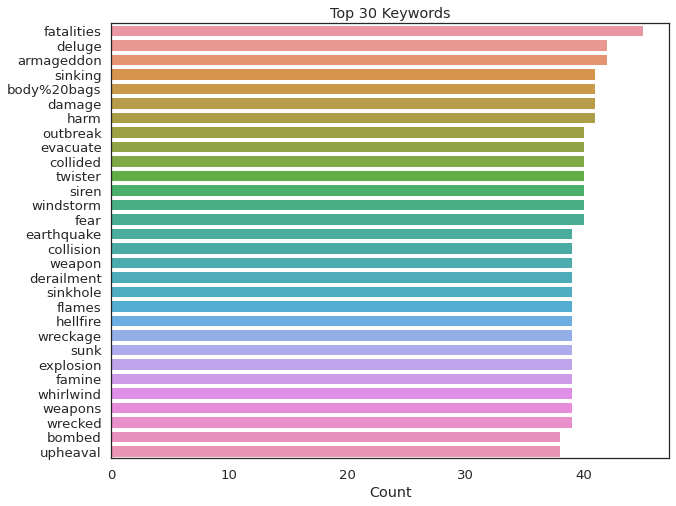

In [27]:
keywords_vc = pd.DataFrame({"Count": train["keyword"].value_counts()})
sns.barplot(y=keywords_vc[0:30].index, x=keywords_vc[0:30]["Count"], orient='h')
plt.title("Top 30 Keywords")
plt.show()

In [28]:
len(train["keyword"].value_counts())

221

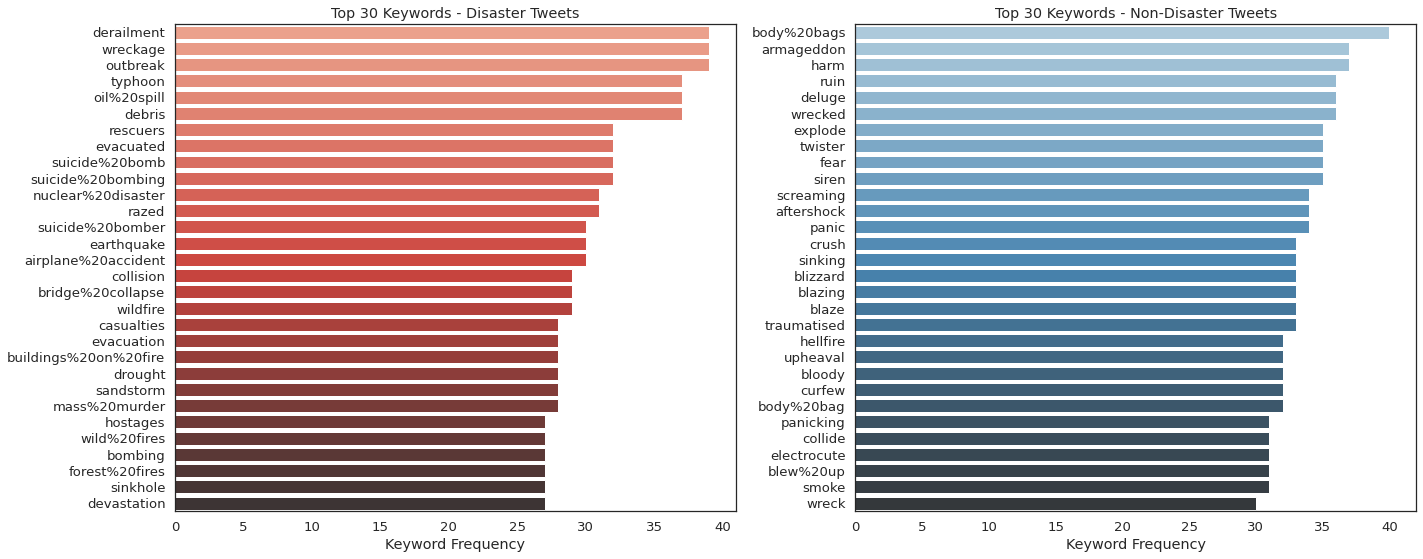

In [29]:
disaster_keywords = train.loc[train["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = train.loc[train["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:30].index, x=disaster_keywords[0:30], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_keywords[0:30].index, x=nondisaster_keywords[0:30], orient='h', ax=ax[1], palette="Blues_d")
ax[0].set_title("Top 30 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

In [30]:
armageddon_tweets = train[(train["keyword"].fillna("").str.contains("armageddon")) & (train["target"] == 0)]
print("An example tweet:\n", armageddon_tweets.iloc[10, 3])
armageddon_tweets.head()

An example tweet:
 @ENews Ben Affleck......I know there's a wife/kids and other girls but I can't help it. I've loved him since Armageddon #eonlinechat


,id,keyword,location,text,target
304,446,armageddon,"California, United States",#PBBan (Temporary:300) avYsss @'aRmageddon | D...,0
305,447,armageddon,"California, United States",#PBBan (Temporary:300) Russaky89 @'aRmageddon ...,0
306,448,armageddon,#FLIGHTCITY UK,((OFFICIAL VID)) #DoubleCups &gt;&gt; https://...,0
307,450,armageddon,NaN,ouvindo Peace Love &amp; Armageddon,0
308,451,armageddon,NaN,Best movie you've ever seen? - Armageddon htt...,0


In [31]:
def keyword_disaster_probabilities(x):
    tweets_w_keyword = np.sum(train["keyword"].fillna("").str.contains(x))
    tweets_w_keyword_disaster = np.sum(train["keyword"].fillna("").str.contains(x) & train["target"] == 1)
    return tweets_w_keyword_disaster / tweets_w_keyword

keywords_vc["Disaster_Probability"] = keywords_vc.index.map(keyword_disaster_probabilities)
keywords_vc.head()

,Count,Disaster_Probability
fatalities,45,0.577778
deluge,42,0.188406
armageddon,42,0.119048
sinking,41,0.195122
body%20bags,41,0.024390


In [32]:
keywords_vc.sort_values(by="Disaster_Probability", ascending=False).head(10)

,Count,Disaster_Probability
debris,37,1.000000
wreckage,39,1.000000
derailment,39,1.000000
outbreak,40,0.975000
typhoon,38,0.973684
oil%20spill,38,0.973684
suicide%20bombing,33,0.969697
suicide%20bomber,31,0.967742
bombing,29,0.951613
suicide%20bomb,35,0.949495


# Location

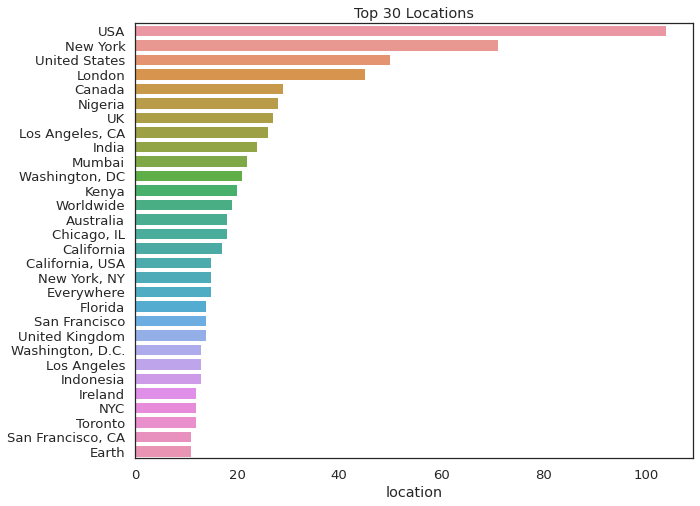

In [33]:
locations_vc = train["location"].value_counts()
sns.barplot(y=locations_vc[0:30].index, x=locations_vc[0:30], orient='h')
plt.title("Top 30 Locations")
plt.show()

In [34]:
len(train["location"].value_counts())

3341

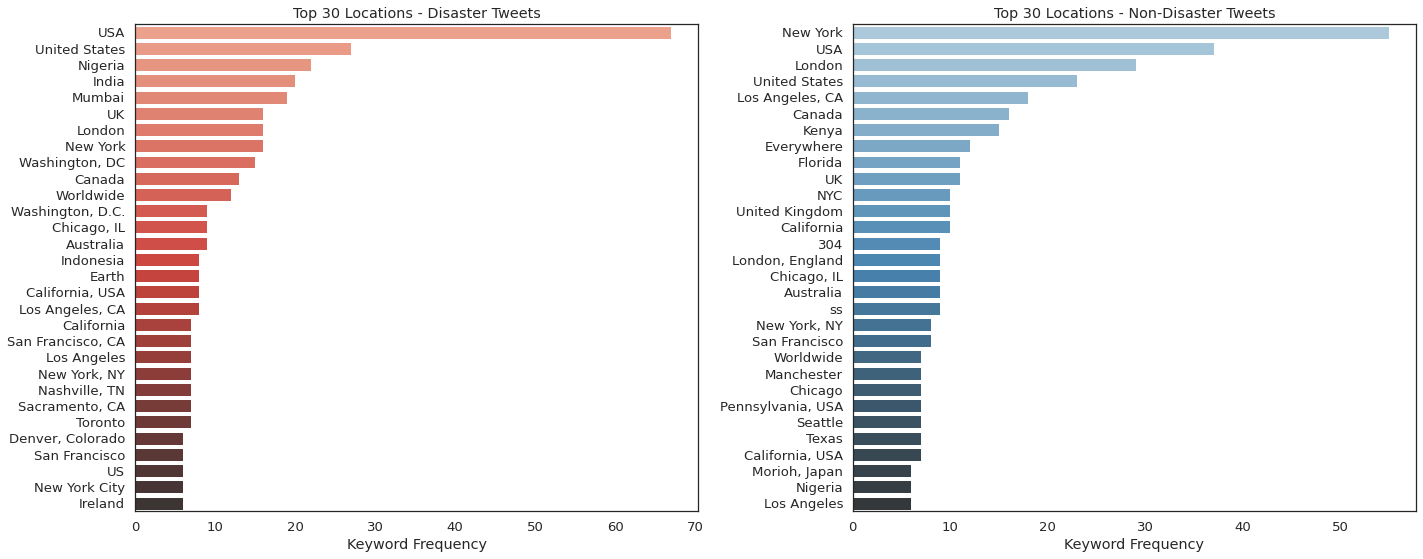

In [35]:
disaster_locations = train.loc[train["target"] == 1]["location"].value_counts()
nondisaster_locations = train.loc[train["target"] == 0]["location"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_locations[0:30].index, x=disaster_locations[0:30], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_locations[0:30].index, x=nondisaster_locations[0:30], orient='h', ax=ax[1], palette="Blues_d")
ax[0].set_title("Top 30 Locations - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Locations - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()


# Text aka Tweet Content

tweet length distribution

/home/boney/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


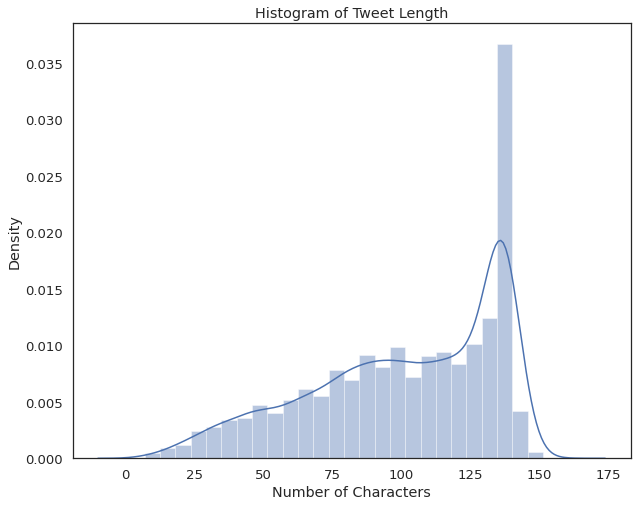

In [36]:
train["tweet_length"] = train["text"].apply(len)
sns.distplot(train["tweet_length"])
plt.title("Histogram of Tweet Length")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

In [37]:
min(train["tweet_length"]), max(train["tweet_length"])

(7, 157)

/home/boney/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/boney/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


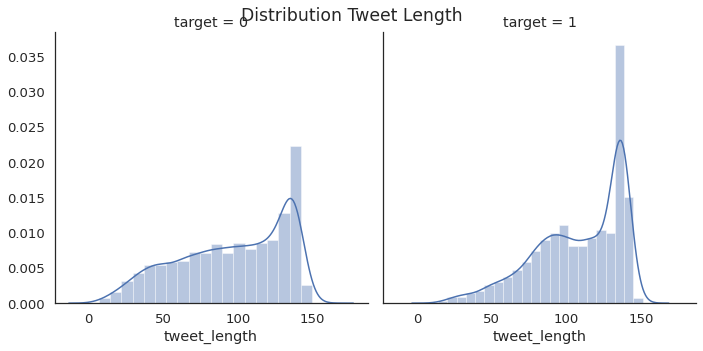

In [38]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "tweet_length")
plt.suptitle("Distribution Tweet Length")
plt.show()

Number of words

/home/boney/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


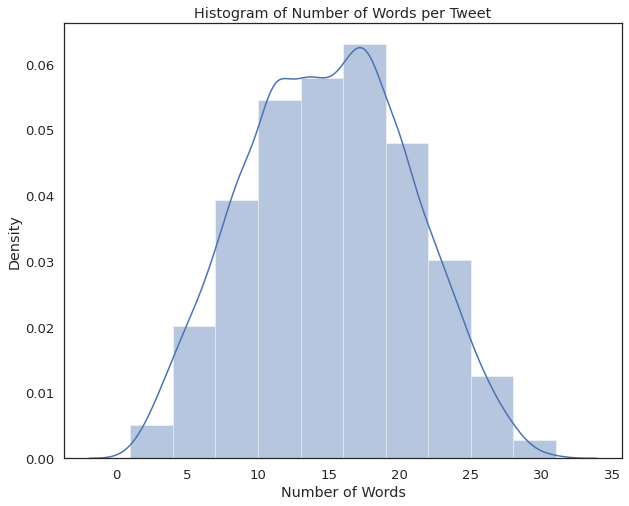

In [39]:
def count_words(x):
    return len(x.split())

train["num_words"] = train["text"].apply(count_words)
sns.distplot(train["num_words"], bins=10)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

/home/boney/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/boney/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


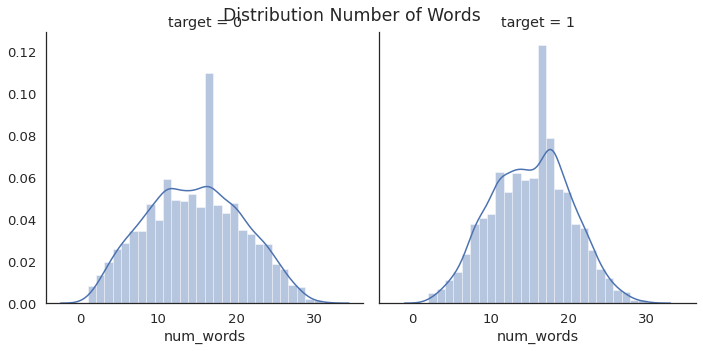

In [40]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "num_words")
plt.suptitle("Distribution Number of Words")
plt.show()

Average Word Legnth

/home/boney/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


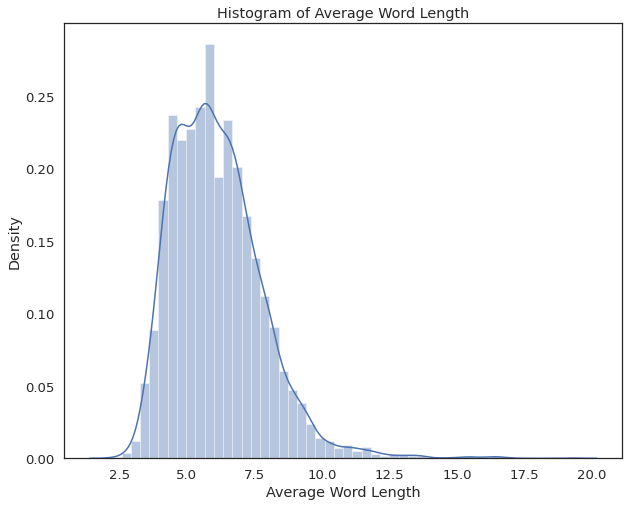

In [41]:
def avg_word_length(x):
    return np.sum([len(w) for w in x.split()]) / len(x.split())

train["avg_word_length"] = train["text"].apply(avg_word_length)
sns.distplot(train["avg_word_length"])
plt.title("Histogram of Average Word Length")
plt.xlabel("Average Word Length")
plt.ylabel("Density")
plt.show()

/home/boney/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/boney/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


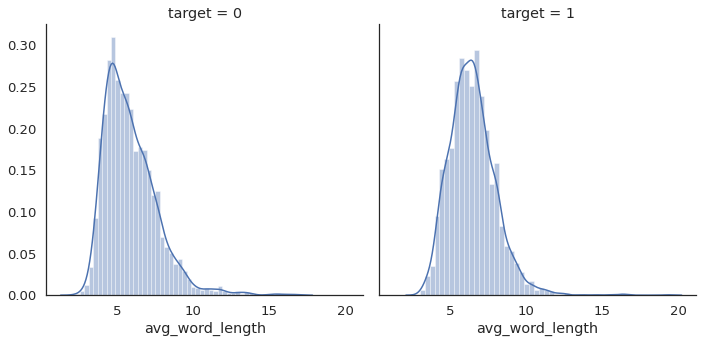

In [42]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "avg_word_length")

Common Stopwords

In [43]:
def create_corpus(target):
    corpus = []

    for w in train.loc[train["target"] == target]["text"].str.split():
        for i in w:
            corpus.append(i)
            
    return corpus

def create_corpus_dict(target):
    corpus = create_corpus(target)
            
    stop_dict = defaultdict(int)
    for word in corpus:
        if word in stopwords:
            stop_dict[word] += 1
    return sorted(stop_dict.items(), key=lambda x:x[1], reverse=True)

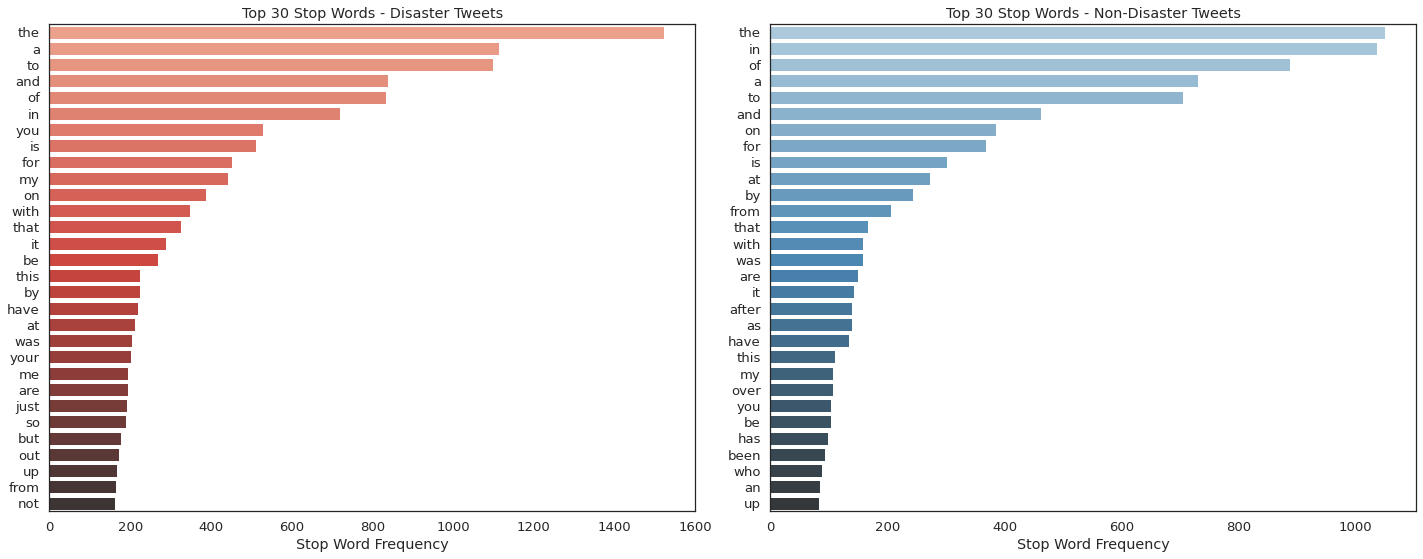

In [44]:
corpus_disaster_dict = create_corpus_dict(0)
corpus_non_disaster_dict = create_corpus_dict(1)

disaster_x, disaster_y = zip(*corpus_disaster_dict)
non_disaster_x, non_disaster_y = zip(*corpus_non_disaster_dict)

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=list(disaster_x)[0:30], x=list(disaster_y)[0:30], orient='h', palette="Reds_d", ax=ax[0])
sns.barplot(y=list(non_disaster_x)[0:30], x=list(non_disaster_y)[0:30], orient='h', palette="Blues_d", ax=ax[1]) 
ax[0].set_title("Top 30 Stop Words - Disaster Tweets")
ax[0].set_xlabel("Stop Word Frequency")
ax[1].set_title("Top 30 Stop Words - Non-Disaster Tweets")
ax[1].set_xlabel("Stop Word Frequency")
plt.tight_layout()
plt.show()

Common non-stop words

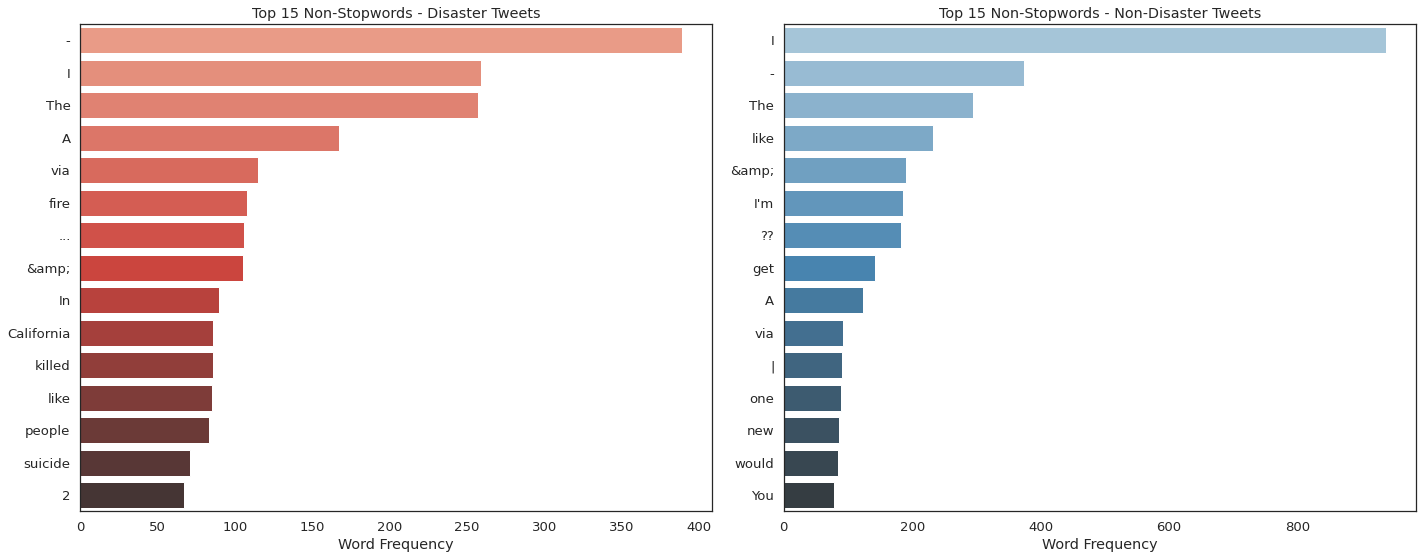

In [45]:
corpus_disaster, corpus_non_disaster = create_corpus(1), create_corpus(0)
counter_disaster, counter_non_disaster = Counter(corpus_disaster), Counter(corpus_non_disaster)
x_disaster, y_disaster, x_non_disaster, y_non_disaster = [], [], [], []

counter = 0
for word, count in counter_disaster.most_common()[0:100]:
    if (word not in stopwords and counter < 15):
        counter += 1
        x_disaster.append(word)
        y_disaster.append(count)

counter = 0
for word, count in counter_non_disaster.most_common()[0:100]:
    if (word not in stopwords and counter < 15):
        counter += 1
        x_non_disaster.append(word)
        y_non_disaster.append(count)

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x=y_disaster, y=x_disaster, orient='h', palette="Reds_d", ax=ax[0])
sns.barplot(x=y_non_disaster, y=x_non_disaster, orient='h', palette="Blues_d", ax=ax[1])
ax[0].set_title("Top 15 Non-Stopwords - Disaster Tweets")
ax[0].set_xlabel("Word Frequency")
ax[1].set_title("Top 15 Non-Stopwords - Non-Disaster Tweets")
ax[1].set_xlabel("Word Frequency")
plt.tight_layout()
plt.show()


Common Bigrams

In [46]:
def bigrams(target):
    corpus = train[train["target"] == target]["text"]
    count_vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = count_vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

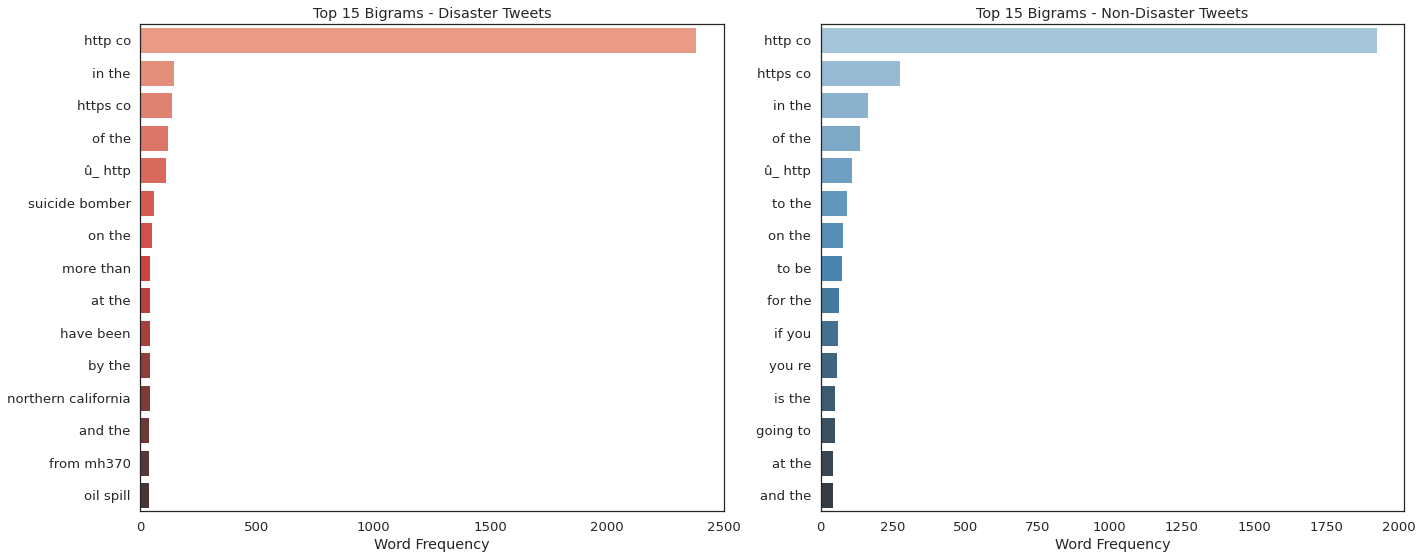

In [47]:
bigrams_disaster = bigrams(1)[:15]
bigrams_non_disaster = bigrams(0)[:15]

x_disaster, y_disaster = map(list, zip(*bigrams_disaster))
x_non_disaster, y_non_disaster = map(list, zip(*bigrams_non_disaster))

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x=y_disaster, y=x_disaster, orient='h', palette="Reds_d", ax=ax[0])
sns.barplot(x=y_non_disaster, y=x_non_disaster, orient='h', palette="Blues_d", ax=ax[1])

ax[0].set_title("Top 15 Bigrams - Disaster Tweets")
ax[0].set_xlabel("Word Frequency")
ax[1].set_title("Top 15 Bigrams - Non-Disaster Tweets")
ax[1].set_xlabel("Word Frequency")
plt.tight_layout()
plt.show()

Not Disaster: 57.03%, Disaster: 42.97%


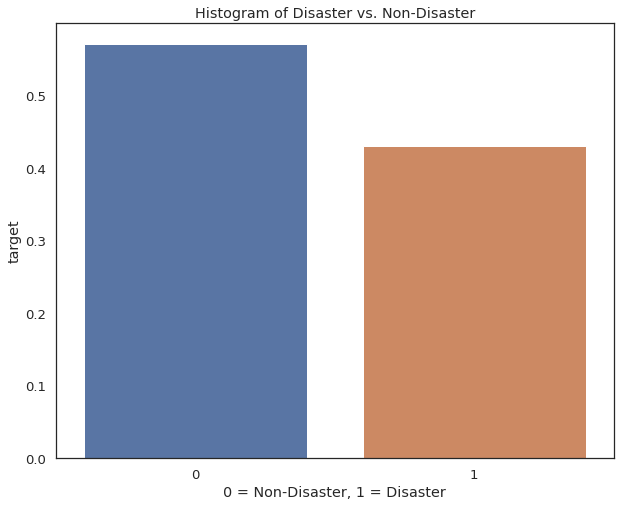

In [48]:
target_vc = train["target"].value_counts(normalize=True)
print("Not Disaster: {:.2%}, Disaster: {:.2%}".format(target_vc[0], target_vc[1]))
sns.barplot(x=target_vc.index, y=target_vc)
plt.title("Histogram of Disaster vs. Non-Disaster")
plt.xlabel("0 = Non-Disaster, 1 = Disaster")
plt.show()

In [49]:
train

,id,keyword,location,text,target,tweet_length,num_words,avg_word_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,4.384615
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,4.571429
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,5.090909
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,7.125000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,4.500000
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,11,6.636364
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,20,5.300000
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,8,7.250000
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137,19,6.263158


In [50]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/boney/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
from nltk.corpus import stopwords

#function for removing pattern
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

# remove '#' handle
train['tweet'] = np.vectorize(remove_pattern)(train['text'], "#[\w]*")
test['tweet'] = np.vectorize(remove_pattern)(test['text'], "#[\w]*") 
train.head()

#Delete everything except alphabet
train['tweet'] = train['tweet'].str.replace("[^a-zA-Z#]", " ")
test['tweet'] = test['tweet'].str.replace("[^a-zA-Z#]", " ")
train.head()


#Dropping words whose length is less than 3
train['tweet'] = train['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
test['tweet'] = test['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
train.head()


#convert all the words into lower case
train['tweet'] = train['tweet'].str.lower()
test['tweet'] = test['tweet'].str.lower()


set(stopwords.words('english'))

# set of stop words
stops = set(stopwords.words('english')) 

# tokens of words  
train['tokenized_sents'] = train.apply(lambda row: nltk.word_tokenize(row['tweet']), axis=1)
test['tokenized_sents'] = test.apply(lambda row: nltk.word_tokenize(row['tweet']), axis=1)

#function to remove stop words
def remove_stops(row):
    my_list = row['tokenized_sents']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

#removing stop words
train['clean_tweet'] = train.apply(remove_stops, axis=1)
test['clean_tweet'] = test.apply(remove_stops, axis=1)
train.drop(["tweet","tokenized_sents"], axis = 1, inplace = True)
test.drop(["tweet","tokenized_sents"], axis = 1, inplace = True)

#re-join the words after tokenization
def rejoin_words(row):
    my_list = row['clean_tweet']
    joined_words = ( " ".join(my_list))
    return joined_words

train['clean_tweet'] = train.apply(rejoin_words, axis=1)
test['clean_tweet'] = test.apply(rejoin_words, axis=1)
train.head()


<ipython-input-51-d3d1c815f94c>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  train['tweet'] = train['tweet'].str.replace("[^a-zA-Z#]", " ")
<ipython-input-51-d3d1c815f94c>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  test['tweet'] = test['tweet'].str.replace("[^a-zA-Z#]", " ")


,id,keyword,location,text,target,tweet_length,num_words,avg_word_length,clean_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,4.384615,deeds reason allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,4.571429,forest fire near ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,5.090909,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,7.125000,people receive evacuation orders california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,4.500000,sent photo ruby smoke pours school


Visualization of all the words using word cloud

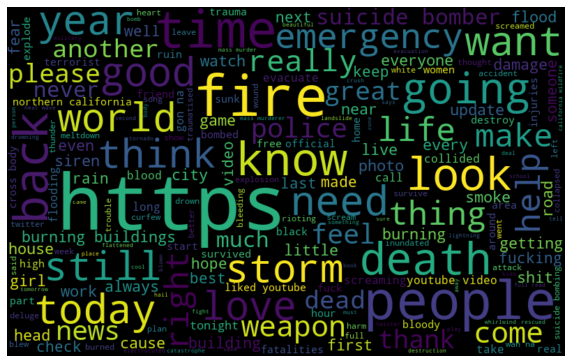

In [52]:
all_word = ' '.join([text for text in train['clean_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_word) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off') 
plt.show()

Visualization of all the words which signify real disaster

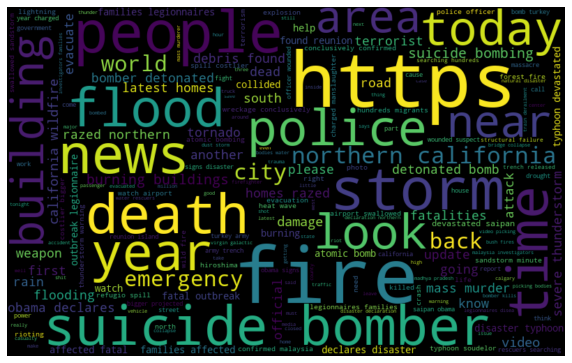

In [53]:
normal_words =' '.join([text for text in train['clean_tweet'][train['target'] == 1]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Visualization of all the words which signify unreal disaster

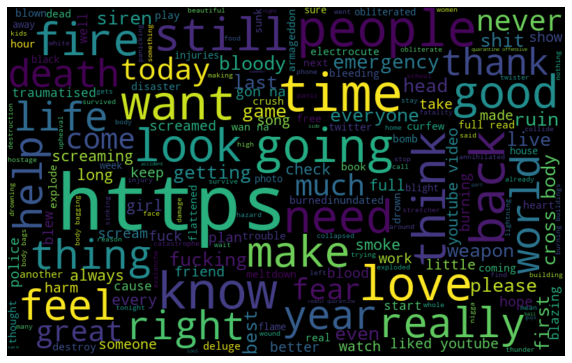

In [54]:
normal_words =' '.join([text for text in train['clean_tweet'][train['target'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [55]:
import gc
import os
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
from transformers import *
from sklearn.metrics import *
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

import os
import gc
import re
import string
import folium
from colorama import Fore, Back, Style, init

import math
import numpy as np
import scipy as sp
import pandas as pd

import random
import networkx as nx
from pandas import Timestamp

from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot

import requests
from IPython.display import HTML

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt

tqdm.pandas()

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import transformers
import tensorflow as tf

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras.models import Model
#from kaggle_datasets import KaggleDatasets
from tensorflow.keras.optimizers import Adam
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import LSTM, GRU, Conv1D, SpatialDropout1D

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *


from sklearn import metrics
from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer  

import nltk
from textblob import TextBlob


from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize

from xgboost import XGBClassifier

stopword=set(STOPWORDS)


lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

np.random.seed(0)
random_state = 29

#!pip3 install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            del obj
    gc.collect()
    
    print("GPU Usage after emptying the cache")
    gpu_usage()



In [56]:
train = pd.read_csv("./nlp_covid/data/kaggle_train.csv")
test = pd.read_csv("./nlp_covid/data/kaggle_test.csv")
sub= pd.read_csv("./nlp_covid/data/kaggle_sample_submission.csv")

In [57]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [58]:
test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [59]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [60]:
sub.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


Preprocessing

In [61]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}


In [62]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

# Factorize elongated words, add ELONG
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

# Factorize repeated punctuation, add REPEAT
def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)


# Remove all punctuations
def remove_all_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

# Remove punctuations
def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')   
    return text

# Remove all english stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

In [63]:
def clean_tweet(text):
    
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    # Lower text, replace abbreviations
    text = text.lower()
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    
    # Remove repeated puntuations / words
    text = remove_elongated_words(text)
    text = remove_repeat_punct(text)

    #text = remove_all_punct(text)
    #text = remove_punct(text)
    #text = remove_stopwords(text)

    return text

In [64]:
# Clean text and add a new feature
train["clean_text"] = train["text"].apply(clean_tweet)
test["clean_text"] = test["text"].apply(clean_tweet)

train["clean_tokens"] = train["clean_text"].apply(lambda x: word_tokenize(x))
test["clean_tokens"] = test["clean_text"].apply(lambda x: word_tokenize(x))

In [65]:
train[['clean_text','text']].head(10)

,clean_text,text
0,our deeds are the reason of this #earthquake m...,Our Deeds are the Reason of this #earthquake M...
1,forest fire near la ronge sask. canada,Forest fire near La Ronge Sask. Canada
2,all residents asked to 'shelter in place' are ...,All residents asked to 'shelter in place' are ...
3,NUMBER people receive #wildfires evacuation or...,"13,000 people receive #wildfires evacuation or..."
4,just got sent this photo from ruby #alaska as ...,Just got sent this photo from Ruby #Alaska as ...
5,#rockyfire update => california hwy. NUMBER cl...,#RockyFire Update => California Hwy. 20 closed...
6,#flood #disaster heavy rain causes flash flood...,#flood #disaster Heavy rain causes flash flood...
7,i'm on top of the hill and i can see a fire in...,I'm on top of the hill and I can see a fire in...
8,there's an emergency evacuation happening now ...,There's an emergency evacuation happening now ...
9,i'm afraid that the tornado is coming to our a...,I'm afraid that the tornado is coming to our a...


Vectorisation

In [66]:
from gensim.models import Word2Vec

skip_gram_model = Word2Vec(train['clean_tokens'],vector_size=150,window=3,min_count=2,sg=1)
skip_gram_model.save("skip_gram.model")
skip_gram_model = Word2Vec.load("skip_gram.model")
skip_gram_model.train(train['clean_tokens'],total_examples=len(train['clean_tokens']),epochs=10)

(911393, 1312770)

In [67]:
cbow_model = Word2Vec(train['clean_tokens'],vector_size=150,window=3,min_count=2)
cbow_model.save("cbow.model")
cbow_model = Word2Vec.load("cbow.model")
cbow_model.train(train['clean_tokens'],total_examples=len(train['clean_tokens']),epochs=10)

(911770, 1312770)

train["clean_tokens"].head(10)
token_list = train["clean_tokens"]

k=150

for words in token_list:
    for word in words:
        if word in skip_gram_model.wv.key_to_index:
            vector = skip_gram_model.wv[n]
        else:
            vector = np.random.rand(k)
    

In [69]:
train["clean_tokens"] = train["text"].apply(lambda x: word_tokenize(x))
test["clean_tokens"] = test["text"].apply(lambda x: word_tokenize(x))

def get_word_embeddings(token_list,vector,k=150):
    if len(token_list) < 1:
        return np.zeros(k)
    else:
        vectorized = [vector.wv[word] if word in vector.wv.key_to_index else np.random.rand(k) for word in token_list] 
        
    sum = np.sum(vectorized,axis=0)
    return sum/len(vectorized) 

In [70]:
#X_train_skip_gram = skip_gram_vectorizer(train['clean_tokens'],skip_gram_model)

tokens = train['clean_tokens']


embeddings = tokens.apply(lambda x: get_word_embeddings(x, skip_gram_model))

In [71]:
max_features=5000

# CountVectorizer
count_vectorizer = CountVectorizer(max_features=max_features)
sparce_matrix_train=count_vectorizer.fit_transform(train['clean_text'])
sparce_matrix_test=count_vectorizer.fit_transform(train['clean_text'])

def count_vector(data):
    count_vectorizer = CountVectorizer()
    vect = count_vectorizer.fit_transform(data)
    return vect, count_vectorizer

def tfidf_vector(data):
    tfidf_vectorizer = TfidfVectorizer()
    vect = tfidf_vectorizer.fit_transform(data)
    return vect, tfidf_vectorizer

def skip_gram_vectorizer(tokens,vector):
        embeddings = tokens.apply(lambda x: get_word_embeddings(x, skip_gram_model))
        return list(embeddings)

def cbow_vectorizer(tokens,vector):
        embeddings = tokens.apply(lambda x: get_word_embeddings(x, cbow_model))
        return list(embeddings)

X_train_count, count_vectorizer = count_vector(train['clean_text'])
X_train_tfidf, tfidf_vectorizer = tfidf_vector(train['clean_text'])
X_train_skip_gram = skip_gram_vectorizer(train['clean_tokens'],skip_gram_model)
X_train_cbow = cbow_vectorizer(train['clean_tokens'],cbow_model)

X_test_count = count_vectorizer.transform(test['clean_text'])                                                     
X_test_tfidf = tfidf_vectorizer.transform(test['clean_text'])
X_test_skip_gram = skip_gram_vectorizer(test['clean_tokens'],skip_gram_model)
X_test_cbow = cbow_vectorizer(test['clean_tokens'],cbow_model)

X_train_skip_gram = np.array(X_train_skip_gram)
X_train_cbow = np.array(X_train_cbow)
X_test_skip_gram = np.array(X_test_skip_gram)
X_test_cbow = np.array(X_test_cbow)


import pickle    

with open('count_vectorizer.pickle', 'wb') as handle:
    pickle.dump(count_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('tfidf_vectorizer.pickle', 'wb') as handle:
    pickle.dump(tfidf_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('skip_gram_model.pickle', 'wb') as handle:
    pickle.dump(skip_gram_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('cbow_model.pickle', 'wb') as handle:
    pickle.dump(cbow_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('cbow_model.pickle', 'wb') as handle:
    pickle.dump(cbow_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('cbow_model.pickle', 'wb') as handle:
    pickle.dump(cbow_model, handle, protocol=pickle.HIGHEST_PROTOCOL)


Models

In [72]:
metrics = pd.DataFrame(columns=['model' ,'vectoriser', 'f1 score', 'train accuracy','test accuracy'])


    LogisticRegression
    SVC
    MultinomialNB
    DecisionTreeClassifier
    KNeighborsClassifier
    RandomForestClassifier

In [73]:
from joblib import dump

def fit_and_predict(model,x_train,x_test,y_train,y_test,vectoriser):
    classifier = model
    classifier_name = str(classifier.__class__.__name__)

    if classifier_name=="MultinomialNB" and (vectoriser=="skip gram vector" or vectoriser=="cbow vector"):
        return

    classifier.fit(x_train,y_train)
    filename = classifier_name +" using "+ str(vectoriser)+".joblib"
    filename = filename.lower().replace(" ","_")
    dump(model, filename=filename)
    y_pred = classifier.predict(x_test)
    cmatrix = confusion_matrix(y_test,y_pred)


    f,ax = plt.subplots(figsize=(3,3))
    sns.heatmap(cmatrix,annot=True,linewidths=0.5,cbar=False,linecolor="red",fmt='.0f',ax=ax)
    plt.xlabel("y_predict")
    plt.ylabel("y_true")
    ax.set(title=str(classifier))
    plt.show()


    f1score = f1_score(y_test,y_pred,average='weighted')
    train_accuracy = round(classifier.score(x_train,y_train)*100)
    test_accuracy =  round(accuracy_score(y_test,y_pred)*100)

    global metrics
    metrics = metrics.append({
                              'model': classifier_name,
                              'f1 score': f1score, 
                              'train accuracy': train_accuracy, 
                              'test accuracy': test_accuracy, 
                              'vectoriser': str(vectoriser),
                             },
                               ignore_index=True
                            )

    print(str(classifier.__class__.__name__) +" using "+ str(vectoriser))
    print(classification_report(y_test,y_pred))    
    print('Accuracy of classifier on training set:{}%'.format(train_accuracy))
    print('Accuracy of classifier on test set:{}%' .format(test_accuracy))

models=[
        XGBClassifier(max_depth=6, n_estimators=1000),
        LogisticRegression(random_state=random_state),
        SVC(random_state=random_state),
        MultinomialNB(),
        DecisionTreeClassifier(random_state = random_state),
        KNeighborsClassifier(),
        RandomForestClassifier(random_state=random_state),
       ]



[12:53:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


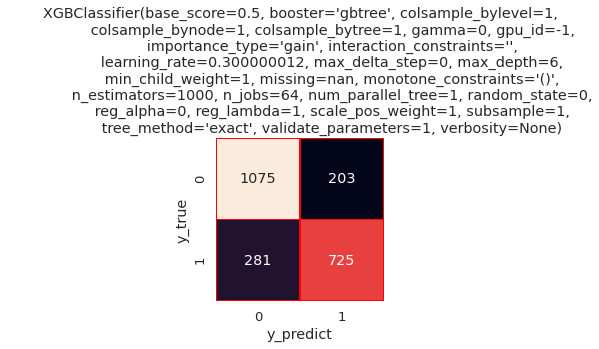

XGBClassifier using Count vector
              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1278
           1       0.78      0.72      0.75      1006

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284

Accuracy of classifier on training set:97%
Accuracy of classifier on test set:79%
[12:53:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


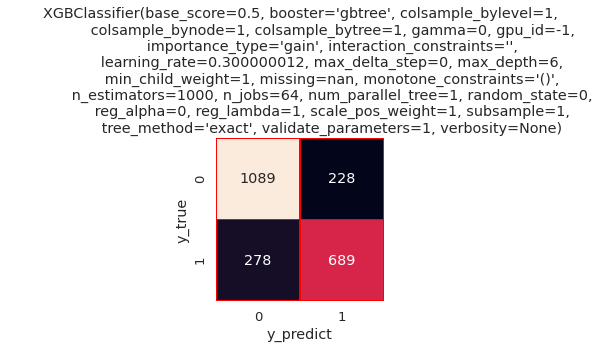

XGBClassifier using Tfidf vector
              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1317
           1       0.75      0.71      0.73       967

    accuracy                           0.78      2284
   macro avg       0.77      0.77      0.77      2284
weighted avg       0.78      0.78      0.78      2284

Accuracy of classifier on training set:99%
Accuracy of classifier on test set:78%
[12:53:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


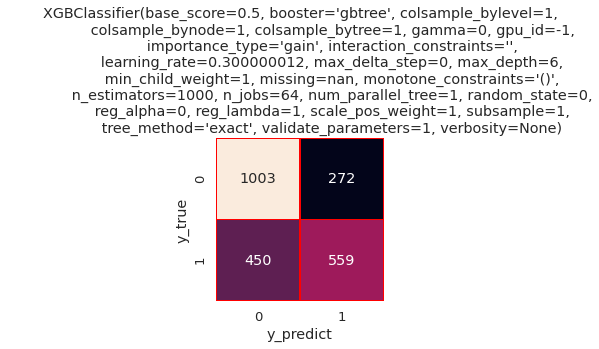

XGBClassifier using skip gram vector
              precision    recall  f1-score   support

           0       0.69      0.79      0.74      1275
           1       0.67      0.55      0.61      1009

    accuracy                           0.68      2284
   macro avg       0.68      0.67      0.67      2284
weighted avg       0.68      0.68      0.68      2284

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:68%
[12:54:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


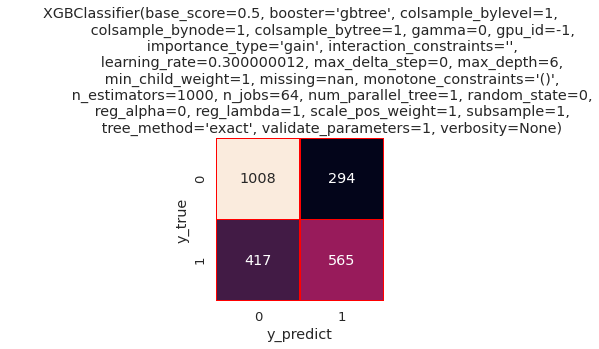

XGBClassifier using cbow vector
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      1302
           1       0.66      0.58      0.61       982

    accuracy                           0.69      2284
   macro avg       0.68      0.67      0.68      2284
weighted avg       0.69      0.69      0.69      2284

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:69%


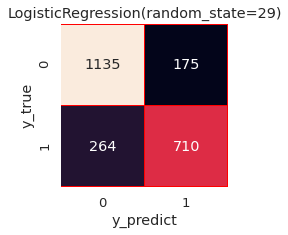

LogisticRegression using Count vector
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1310
           1       0.80      0.73      0.76       974

    accuracy                           0.81      2284
   macro avg       0.81      0.80      0.80      2284
weighted avg       0.81      0.81      0.81      2284

Accuracy of classifier on training set:96%
Accuracy of classifier on test set:81%


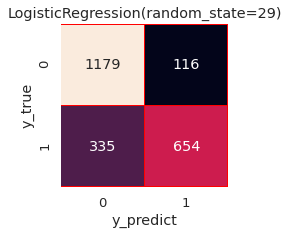

LogisticRegression using Tfidf vector
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1295
           1       0.85      0.66      0.74       989

    accuracy                           0.80      2284
   macro avg       0.81      0.79      0.79      2284
weighted avg       0.81      0.80      0.80      2284

Accuracy of classifier on training set:88%
Accuracy of classifier on test set:80%


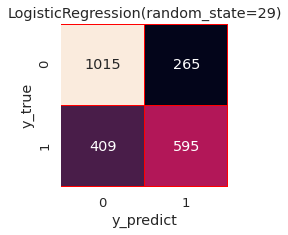

LogisticRegression using skip gram vector
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1280
           1       0.69      0.59      0.64      1004

    accuracy                           0.70      2284
   macro avg       0.70      0.69      0.69      2284
weighted avg       0.70      0.70      0.70      2284

Accuracy of classifier on training set:73%
Accuracy of classifier on test set:70%


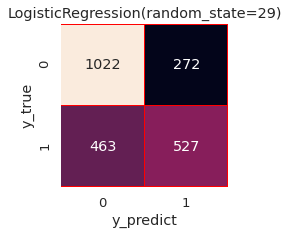

LogisticRegression using cbow vector
              precision    recall  f1-score   support

           0       0.69      0.79      0.74      1294
           1       0.66      0.53      0.59       990

    accuracy                           0.68      2284
   macro avg       0.67      0.66      0.66      2284
weighted avg       0.68      0.68      0.67      2284

Accuracy of classifier on training set:72%
Accuracy of classifier on test set:68%


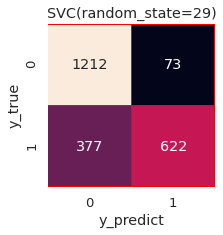

SVC using Count vector
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      1285
           1       0.89      0.62      0.73       999

    accuracy                           0.80      2284
   macro avg       0.83      0.78      0.79      2284
weighted avg       0.82      0.80      0.80      2284

Accuracy of classifier on training set:93%
Accuracy of classifier on test set:80%


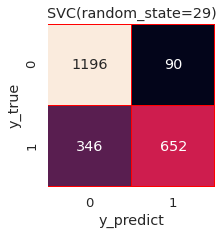

SVC using Tfidf vector
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1286
           1       0.88      0.65      0.75       998

    accuracy                           0.81      2284
   macro avg       0.83      0.79      0.80      2284
weighted avg       0.82      0.81      0.80      2284

Accuracy of classifier on training set:96%
Accuracy of classifier on test set:81%


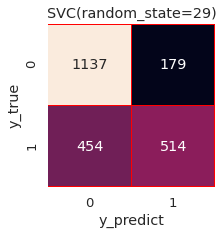

SVC using skip gram vector
              precision    recall  f1-score   support

           0       0.71      0.86      0.78      1316
           1       0.74      0.53      0.62       968

    accuracy                           0.72      2284
   macro avg       0.73      0.70      0.70      2284
weighted avg       0.73      0.72      0.71      2284

Accuracy of classifier on training set:75%
Accuracy of classifier on test set:72%


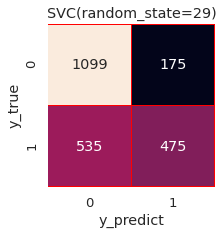

SVC using cbow vector
              precision    recall  f1-score   support

           0       0.67      0.86      0.76      1274
           1       0.73      0.47      0.57      1010

    accuracy                           0.69      2284
   macro avg       0.70      0.67      0.66      2284
weighted avg       0.70      0.69      0.67      2284

Accuracy of classifier on training set:73%
Accuracy of classifier on test set:69%


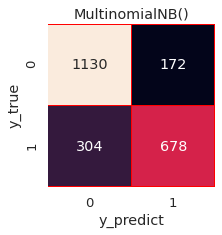

MultinomialNB using Count vector
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1302
           1       0.80      0.69      0.74       982

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284

Accuracy of classifier on training set:90%
Accuracy of classifier on test set:79%


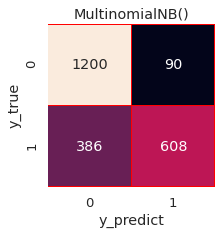

MultinomialNB using Tfidf vector
              precision    recall  f1-score   support

           0       0.76      0.93      0.83      1290
           1       0.87      0.61      0.72       994

    accuracy                           0.79      2284
   macro avg       0.81      0.77      0.78      2284
weighted avg       0.81      0.79      0.78      2284

Accuracy of classifier on training set:88%
Accuracy of classifier on test set:79%


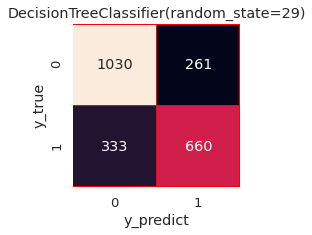

DecisionTreeClassifier using Count vector
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1291
           1       0.72      0.66      0.69       993

    accuracy                           0.74      2284
   macro avg       0.74      0.73      0.73      2284
weighted avg       0.74      0.74      0.74      2284

Accuracy of classifier on training set:99%
Accuracy of classifier on test set:74%


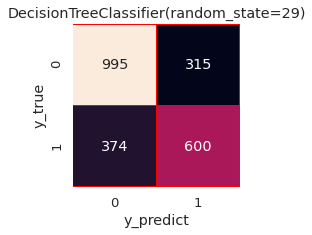

DecisionTreeClassifier using Tfidf vector
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      1310
           1       0.66      0.62      0.64       974

    accuracy                           0.70      2284
   macro avg       0.69      0.69      0.69      2284
weighted avg       0.70      0.70      0.70      2284

Accuracy of classifier on training set:99%
Accuracy of classifier on test set:70%


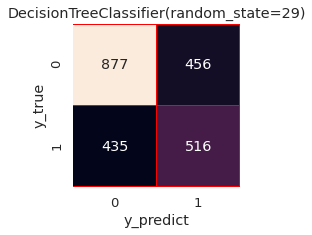

DecisionTreeClassifier using skip gram vector
              precision    recall  f1-score   support

           0       0.67      0.66      0.66      1333
           1       0.53      0.54      0.54       951

    accuracy                           0.61      2284
   macro avg       0.60      0.60      0.60      2284
weighted avg       0.61      0.61      0.61      2284

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:61%


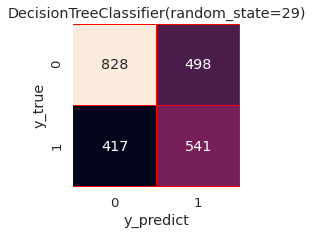

DecisionTreeClassifier using cbow vector
              precision    recall  f1-score   support

           0       0.67      0.62      0.64      1326
           1       0.52      0.56      0.54       958

    accuracy                           0.60      2284
   macro avg       0.59      0.59      0.59      2284
weighted avg       0.60      0.60      0.60      2284

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:60%


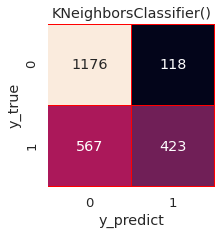

KNeighborsClassifier using Count vector
              precision    recall  f1-score   support

           0       0.67      0.91      0.77      1294
           1       0.78      0.43      0.55       990

    accuracy                           0.70      2284
   macro avg       0.73      0.67      0.66      2284
weighted avg       0.72      0.70      0.68      2284

Accuracy of classifier on training set:80%
Accuracy of classifier on test set:70%


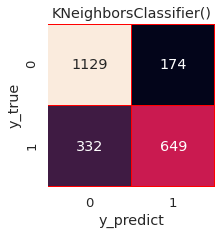

KNeighborsClassifier using Tfidf vector
              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1303
           1       0.79      0.66      0.72       981

    accuracy                           0.78      2284
   macro avg       0.78      0.76      0.77      2284
weighted avg       0.78      0.78      0.78      2284

Accuracy of classifier on training set:84%
Accuracy of classifier on test set:78%


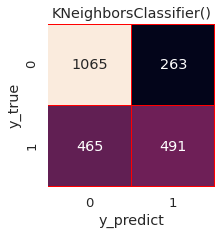

KNeighborsClassifier using skip gram vector
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      1328
           1       0.65      0.51      0.57       956

    accuracy                           0.68      2284
   macro avg       0.67      0.66      0.66      2284
weighted avg       0.68      0.68      0.67      2284

Accuracy of classifier on training set:78%
Accuracy of classifier on test set:68%


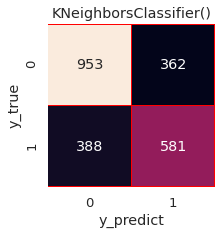

KNeighborsClassifier using cbow vector
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      1315
           1       0.62      0.60      0.61       969

    accuracy                           0.67      2284
   macro avg       0.66      0.66      0.66      2284
weighted avg       0.67      0.67      0.67      2284

Accuracy of classifier on training set:78%
Accuracy of classifier on test set:67%


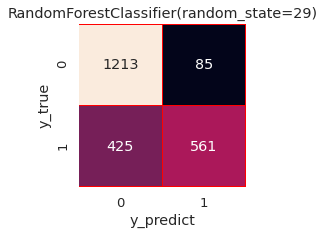

RandomForestClassifier using Count vector
              precision    recall  f1-score   support

           0       0.74      0.93      0.83      1298
           1       0.87      0.57      0.69       986

    accuracy                           0.78      2284
   macro avg       0.80      0.75      0.76      2284
weighted avg       0.80      0.78      0.77      2284

Accuracy of classifier on training set:99%
Accuracy of classifier on test set:78%


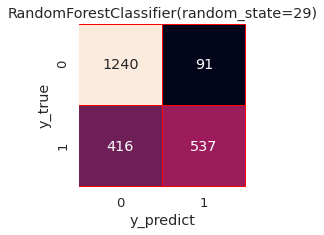

RandomForestClassifier using Tfidf vector
              precision    recall  f1-score   support

           0       0.75      0.93      0.83      1331
           1       0.86      0.56      0.68       953

    accuracy                           0.78      2284
   macro avg       0.80      0.75      0.75      2284
weighted avg       0.79      0.78      0.77      2284

Accuracy of classifier on training set:99%
Accuracy of classifier on test set:78%


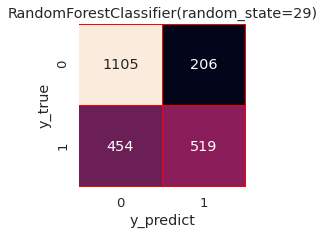

RandomForestClassifier using skip gram vector
              precision    recall  f1-score   support

           0       0.71      0.84      0.77      1311
           1       0.72      0.53      0.61       973

    accuracy                           0.71      2284
   macro avg       0.71      0.69      0.69      2284
weighted avg       0.71      0.71      0.70      2284

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:71%


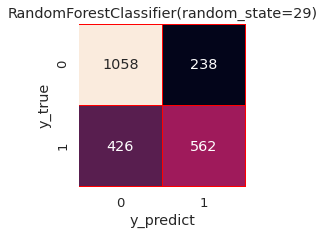

RandomForestClassifier using cbow vector
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      1296
           1       0.70      0.57      0.63       988

    accuracy                           0.71      2284
   macro avg       0.71      0.69      0.69      2284
weighted avg       0.71      0.71      0.70      2284

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:71%


In [74]:
for model in models:
    y = train.target

    x = X_train_count
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
    fit_and_predict(model,x_train,x_test,y_train,y_test,'Count vector')
    
    x = X_train_tfidf
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
    fit_and_predict(model,x_train,x_test,y_train,y_test, 'Tfidf vector')
    
    x = X_train_skip_gram
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
    fit_and_predict(model,x_train,x_test,y_train,y_test, 'skip gram vector')
    
    x = X_train_cbow
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
    fit_and_predict(model,x_train,x_test,y_train,y_test, 'cbow vector')    

In [75]:
metrics = metrics.sort_values('f1 score',ascending=False)


In [76]:
metrics


,model,vectoriser,f1 score,train accuracy,test accuracy
4,LogisticRegression,Count vector,0.806350,96,81
9,SVC,Tfidf vector,0.803704,96,81
5,LogisticRegression,Tfidf vector,0.797945,88,80
8,SVC,Count vector,0.795719,93,80
12,MultinomialNB,Count vector,0.789113,90,79
0,XGBClassifier,Count vector,0.786955,97,79
13,MultinomialNB,Tfidf vector,0.784089,88,79
1,XGBClassifier,Tfidf vector,0.777583,99,78
19,KNeighborsClassifier,Tfidf vector,0.775089,84,78
23,RandomForestClassifier,Tfidf vector,0.767282,99,78


In [77]:
free_gpu_cache()


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 40% |
|  1 |  0% |  1% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 16% |  1% |
|  1 |  0% |  1% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |


LSTM

In [78]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,GRU, Dropout, Activation, Input, Flatten, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras import layers
from keras import optimizers
from functools import reduce


In [79]:
def train_lstm(x_train,x_test,y_train,y_test,vectorizer_name,vocab_size,input_length):
    epochs = 1
    verbose = 1
    batch_size = 32
    embed_dim = 32
    optimizer = optimizers.Adam(lr=0.002)
    
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim,input_length = input_length))
    model.add(Dropout(0.2))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
    
    print(model.summary())

    model.fit(x_train, y_train, epochs = epochs, verbose = verbose, batch_size=batch_size, validation_data=(x_test, y_test))

    model_name = "LSTM using "+ vectorizer_name 
    model.save(model_name)
    y_pred = model.predict(x_test)

    f1score = f1_score(y_test,y_pred.round(),average='weighted')
    train_accuracy = round(accuracy_score(y_train,reduce(list.__add__, model.predict(x_train).round().tolist()))*100)
    test_accuracy =  round(accuracy_score(y_test,y_pred.round())*100)

    global metrics
    metrics = metrics.append({
                              'model': model_name,
                              'f1 score': f1score, 
                              'train accuracy': train_accuracy, 
                              'test accuracy': test_accuracy, 
                              'vectoriser': vectorizer_name,
                             },
                               ignore_index=True
                            )

    print(model_name)
    print(classification_report(y_test,y_pred.round()))    
    print('Accuracy of classifier on training set:{}%'.format(train_accuracy))
    print('Accuracy of classifier on test set:{}%' .format(test_accuracy))

In [81]:
##### y = train['target'].values


# x_train, x_test, y_train, y_test = train_test_split(X_train_cbow),y, test_size = 0.3)
# train_lstm(x_train,x_test,y_train,y_test, 'cbow vector',5329,150)

x_train, x_test, y_train, y_test = train_test_split(X_train_skip_gram,y, test_size = 0.3)
train_lstm(x_train,x_test,y_train,y_test, 'skip gram vector',5329,150)

# x_train, x_test, y_train, y_test = train_test_split(X_train_count,y, test_size = 0.3)
# train_lstm(x_train,x_test,y_train,y_test,'Count vector',14455,7613)

# x_train, x_test, y_train, y_test = train_test_split(X_train_tfidf,y, test_size = 0.3)
# train_lstm(x_train,x_test,y_train,y_test, 'Tfidf vector',14455,7613)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 32)           170528    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 178,881
Trainable params: 178,881
Non-trainable params: 0
_________________________________________________________________
None
167/167 [==============================] - 28s 157ms/step - loss: 0.6870 - accuracy: 0.5646 - val_loss: 0.6846 - val_accuracy: 0.5665
INFO:tensorflow:Assets written to: LSTM using skip gram vector/assets
LSTM using skip gram vector
         

In [85]:


%reset -f



In [1]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import gc
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            del obj
    gc.collect()
    
    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()



Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  1% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% |  1% |
|  1 |  0% |  1% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |


/home/boney/.local/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:144: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


# Electra

In [2]:
import re
import torch
from transformers import ElectraTokenizer, ElectraForSequenceClassification,AdamW
import torch
from sklearn.metrics import classification_report
import random
import time
import datetime
import numpy as np
import pandas as pd
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split


In [3]:
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


We will use the GPU: GeForce RTX 2080 Ti


In [4]:
train = pd.read_csv("./nlp_covid/data/kaggle_train.csv")
test = pd.read_csv("./nlp_covid/data/kaggle_test.csv")

df_train= train
df_test= test

In [5]:
def preprocess(text):
    text=text.lower()
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    text = re.sub(r"(?:\@)\w+", '', text)
    text=text.encode("ascii",errors="ignore").decode()
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    text=" ".join(text.split())
    return text
df_train['text'] = df_train['text'].apply(preprocess)
df_test['text'] = df_test['text'].apply(preprocess)
df_train=df_train[df_train["text"]!='']

In [6]:


df_train=df_train[["text","target"]]



In [7]:
texts = df_train.text.values
labels = df_train.target.values


In [8]:
torch.cuda.empty_cache()
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator',num_labels=2)
model.cuda()

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [10]:
indices=tokenizer.batch_encode_plus(texts,max_length=64,add_special_tokens=True, return_attention_mask=True,padding='max_length',truncation=True)
input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]



In [11]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)



In [12]:
# Converting all of our data into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [13]:
batch_size = 32

# the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [14]:
optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [15]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [16]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [17]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # As we unpack the batch, we'll also copy each tensor to the GPU  
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)

        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
      
print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    50  of    189.    Elapsed: 0:00:07.
  Batch   100  of    189.    Elapsed: 0:00:14.
  Batch   150  of    189.    Elapsed: 0:00:21.
  Average training loss: 0.54
  Training epoch took: 0:00:26

======== Epoch 2 / 5 ========
Training...
  Batch    50  of    189.    Elapsed: 0:00:07.
  Batch   100  of    189.    Elapsed: 0:00:14.
  Batch   150  of    189.    Elapsed: 0:00:21.
  Average training loss: 0.42
  Training epoch took: 0:00:27

======== Epoch 3 / 5 ========
Training...
  Batch    50  of    189.    Elapsed: 0:00:07.
  Batch   100  of    189.    Elapsed: 0:00:14.
  Batch   150  of    189.    Elapsed: 0:00:22.
  Average training loss: 0.38
  Training epoch took: 0:00:27

======== Epoch 4 / 5 ========
Training...
  Batch    50  of    189.    Elapsed: 0:00:07.
  Batch   100  of    189.    Elapsed: 0:00:15.
  Batch   150  of    189.    Elapsed: 0:00:22.
  Average training loss: 0.35
  Training epoch took: 0:00:28

======== Epoch 5 / 

In [18]:
# Validation               

print("")
print("Running Validation...")

t0 = time.time()

model.eval()

preds=[]
true=[]

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    preds.append(logits)
    true.append(label_ids)
    # Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Validation took: {:}".format(format_time(time.time() - t0)))


Running Validation...
Accuracy: 0.82
Validation took: 0:00:02


In [146]:
report = {}
report['model'] = 'Electra'
report['test accuracy'] = 0.82
metrics = metrics.append(report,ignore_index=True)


# Predictions

In [20]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in preds for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true for item in sublist]

In [23]:
comments1 = df_test.text.values

indices1=tokenizer.batch_encode_plus(comments1,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)


# Set the batch size.  
batch_size = 32 

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

In [24]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader1:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids1, b_input_mask1 = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()
  
  
  # Store predictions and true labels
  predictions.append(logits1)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

Predicting labels for 3,263 test sentences...


In [25]:
sample_sub=pd.read_csv('./nlp_covid/data/kaggle_sample_submission.csv')
submit=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':flat_predictions})
submit.to_csv('submit_electra.csv', index=False)
print(submit)

         id  target
0         0       1
1         2       1
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       0
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       1

[3263 rows x 2 columns]


# Using Data Leak (NOT recommended!)

In [153]:
df_leak = pd.read_csv('./nlp_covid/data/socialmedia-disaster-tweets-DFE.csv', encoding ='ISO-8859-1')[['choose_one', 'text']]

# Creating target and id
df_leak['target'] = (df_leak['choose_one'] == 'Relevant').astype(np.int8)
df_leak['id'] = df_leak.index.astype(np.int16)
df_leak.drop(columns=['choose_one', 'text'], inplace=True)

# Merging target to test set
df_test = df_test.merge(df_leak, on=['id'], how='left')

print('Leaked Data Set Shape = {}'.format(df_leak.shape))
print('Leaked Data Set Memory Usage = {:.2f} MB'.format(df_leak.memory_usage().sum() / 1024**2))
print(df_test)
submission = pd.read_csv("./nlp_covid/data/kaggle_sample_submission.csv")
submission['target'] = df_test['target'].values
submission.to_csv('submission.csv', index=False)
print(submission)

Leaked Data Set Shape = (10876, 2)
Leaked Data Set Memory Usage = 0.09 MB
         id keyword location  \
0         0     NaN      NaN   
1         2     NaN      NaN   
2         3     NaN      NaN   
3         9     NaN      NaN   
4        11     NaN      NaN   
...     ...     ...      ...   
3258  10861     NaN      NaN   
3259  10865     NaN      NaN   
3260  10868     NaN      NaN   
3261  10874     NaN      NaN   
3262  10875     NaN      NaN   

                                                   text  target_x  target_y  \
0                    just happened a terrible car crash         1         1   
1     heard about earthquake is different cities sta...         1         1   
2     there is a forest fire at spot pond geese are ...         1         1   
3                 apocalypse lighting spokane wildfires         1         1   
4         typhoon soudelor kills 28 in china and taiwan         1         1   
...                                                 ...       ...  

# BERT

In [91]:
train = pd.read_csv("./nlp_covid/data/kaggle_train.csv")
test = pd.read_csv("./nlp_covid/data/kaggle_test.csv")
submit = pd.read_csv("./nlp_covid/data/submission.csv")

test['Label'] = submit['target']

train = train.rename(columns={'id': 'Id'})
train = train.rename(columns={'text': 'Text'})
train = train.rename(columns={'target': 'Label'})
test = test.rename(columns={'id': 'Id'})
test = test.rename(columns={'text': 'Text'})


train = train.drop('keyword', axis = 1)
train = train.drop('location', axis = 1)
test = test.drop('keyword', axis = 1)
test = test.drop('location', axis = 1)

valid = train.sample(n=1000, replace=False)
train = train.drop(valid.index)

print(train.info())
print(valid.info())
print(test.info())
print()
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      6613 non-null   int64 
 1   Text    6613 non-null   object
 2   Label   6613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 206.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 843 to 1569
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      1000 non-null   int64 
 1   Text    1000 non-null   object
 2   Label   1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 31.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      3263 non-null   int64 
 1   Text    3263 non-null   object
 2   Label   3263 non-null   int64 
dtypes: int64(2), object(1)

,Id,Text,Label
0,1,Our Deeds are the Reason of this #earthquake M...,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
5,8,#RockyFire Update => California Hwy. 20 closed...,1
6,10,#flood #disaster Heavy rain causes flash flood...,1


In [92]:
print('Number of training sentences: {:,}\n'.format(train.shape[0]))
print('Number of validation sentences: {:,}\n'.format(valid.shape[0]))
print('Number of test sentences: {:,}\n'.format(test.shape[0]))

Number of training sentences: 6,613

Number of validation sentences: 1,000

Number of test sentences: 3,263



In [93]:
def clean_text(text):
    
    text = text.lower() #lowercase
    
    text = re.sub(r'[!]+','!',text)
    text = re.sub(r'[?]+','?',text)
    text = re.sub(r'[.]+','.',text)
    text = re.sub(r"'","",text)
    text = re.sub('\s+', '', text).strip() # Remove and double spaces
    text = re.sub(r'&amp;?',r'and', text) # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text) # Remove URLs
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+','',text) #remove some puncts (except . ! # ?)
    
    return text

#train['text'] = train['text'].apply(clean_text)
#test['text'] = test['text'].apply(clean_text)

train.head()

,Id,Text,Label
0,1,Our Deeds are the Reason of this #earthquake M...,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
5,8,#RockyFire Update => California Hwy. 20 closed...,1
6,10,#flood #disaster Heavy rain causes flash flood...,1


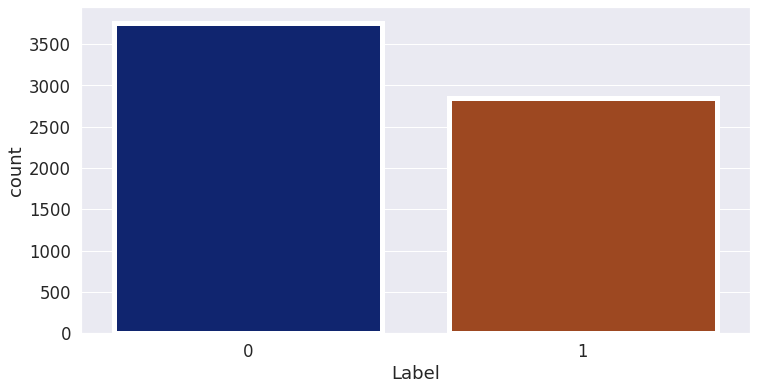

Number of informative and uninformative tweets contained in the train dataset:
0    3760
1    2853
Name: Label, dtype: int64


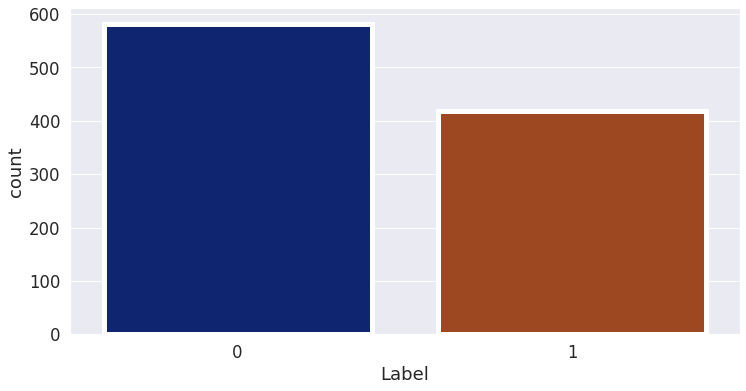

Number of informative and uninformative tweets contained in the valid dataset:
0    582
1    418
Name: Label, dtype: int64


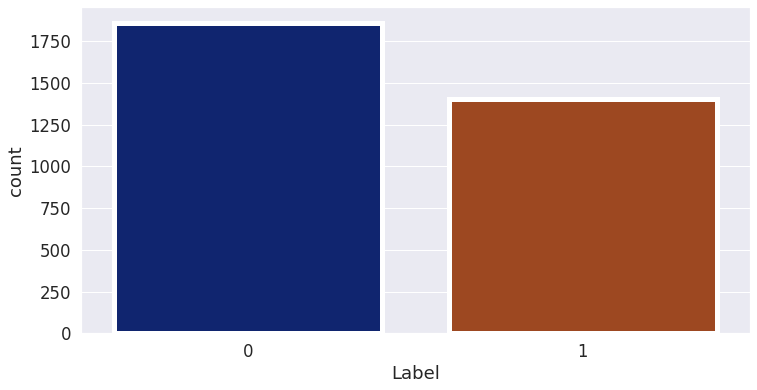

Number of informative and uninformative tweets contained in the test dataset:
0    1861
1    1402
Name: Label, dtype: int64


In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot count of true and false tweets in the train set
sns.countplot(x="Label", data=train, palette="dark", linewidth=5)
plt.show()

print('Number of informative and uninformative tweets contained in the train dataset:')
print(train['Label'].value_counts())

sns.countplot(x="Label", data=valid, palette="dark", linewidth=5)
plt.show()

print('Number of informative and uninformative tweets contained in the valid dataset:')
print(valid['Label'].value_counts())

# No label in Kaggle test set
sns.countplot(x="Label", data=test, palette="dark", linewidth=5)
plt.show()

print('Number of informative and uninformative tweets contained in the test dataset:')
print(test['Label'].value_counts())

In [95]:
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch.nn.functional as F

# Get the lists of sentences and their labels.
train_sentences = train.Text.values
train_labels = train.Label.values

valid_sentences = valid.Text.values
valid_labels = valid.Label.values

test_sentences = test.Text.values
test_labels = test.Label.values

# Load the BERT tokenizer.
#To feed our text to BERT, it must be split into tokens, and then these tokens must be 
#mapped to their index in the tokenizer vocabulary.
#The tokenization must be performed by the tokenizer included with BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [96]:
# Print the original sentence.
print('train Original: ', train_sentences[0])
print('valid Original: ', valid_sentences[0])
print('test Original: ', test_sentences[0])

# Print the sentence split into tokens.
print('Tokenized train: ', tokenizer.tokenize(train_sentences[0]))
print('Tokenized valid: ', tokenizer.tokenize(valid_sentences[0]))
print('Tokenized test: ', tokenizer.tokenize(test_sentences[0]))

# Print the sentence mapped to token ids.
print('train Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sentences[0])))
print('valid Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(valid_sentences[0])))
print('test Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(test_sentences[0])))

train Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
valid Original:  Market News: Activision Blizzard Cognizant Technology First Solar http://t.co/gkNRP0e8Qs
test Original:  Just happened a terrible car crash
Tokenized train:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Tokenized valid:  ['market', 'news', ':', 'act', '##ivision', 'blizzard', 'co', '##gni', '##zan', '##t', 'technology', 'first', 'solar', 'http', ':', '/', '/', 't', '.', 'co', '/', 'g', '##k', '##nr', '##p', '##0', '##e', '##8', '##q', '##s']
Tokenized test:  ['just', 'happened', 'a', 'terrible', 'car', 'crash']
train Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]
valid Token IDs:  [3006, 2739, 1024, 2552, 24607, 21689, 2522, 29076, 13471, 2102, 2974, 2034, 5943, 8299, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 1043, 2243, 16118, 2361, 2692, 2063, 2620, 4160, 2015]
t

In [97]:
train_max_len = 0
valid_max_len = 0
test_max_len = 0

# Decide on a constant maximum sentence length for padding / truncating to 
# by choosing the max length of the sentences in the dataset.
for sent in train_sentences:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)

  # Update the maximum sentence length.
  train_max_len = max(train_max_len, len(input_ids))

for sent in valid_sentences:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)

  # Update the maximum sentence length.
  valid_max_len = max(valid_max_len, len(input_ids))

for sent in test_sentences:
  # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
  input_ids = tokenizer.encode(sent, add_special_tokens=True)

  # Update the maximum sentence length.
  test_max_len = max(test_max_len, len(input_ids))

print('train max sentence length: ', train_max_len)
print('valid max sentence length: ', valid_max_len)
print('test max sentence length: ', test_max_len)

train max sentence length:  84
valid max sentence length:  68
test max sentence length:  73


In [98]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
train_input_ids = []
train_attention_masks = []
valid_input_ids = []
valid_attention_masks = []

# For every sentence...
for sent in train_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    train_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    train_attention_masks.append(encoded_dict['attention_mask'])


# For every sentence...
for sent in valid_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    valid_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    valid_attention_masks.append(encoded_dict['attention_mask'])


# Convert the lists into tensors.
train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)

valid_input_ids = torch.cat(valid_input_ids, dim=0)
valid_attention_masks = torch.cat(valid_attention_masks, dim=0)

train_labels = torch.tensor(train_labels)
valid_labels = torch.tensor(valid_labels)

# Print sentence 0, now as a list of IDs.
print('train Original sentence: ', train_sentences[0])
print('train Token IDs list:', train_input_ids[0])

print('validation Original sentence: ', valid_sentences[0])
print('validation Token IDs list:', valid_input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/boney/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


train Original sentence:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
train Token IDs list: tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  1001,  8372,
         2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
validation Original sentence:  Market News: Activision Blizzard Cognizant Technology First Solar http://t.co/gkNRP0e8Qs
validation Token IDs list: tensor([  101,  3006,  2739,  1024,  2552, 24607, 21689,  2522, 29076, 13471,
         2102,  2974,  2034,  5943,  8299,  1024,  1013,  1013,  1056,  1012,
         2522,  1013,  1043,  2243, 16118,  2361,  2692,  2063,  2620,  41

In [99]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
valid_dataset = TensorDataset(valid_input_ids, valid_attention_masks, valid_labels)

# Create a 80-20 train-validation split.
# Calculate the number of samples to include in each set.
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# print('{:>5,} training samples'.format(train_size))
# print('{:>5,} validation samples'.format(val_size))

In [100]:
# Define a batch size value for the DataLoader
# It is not recommended to use a high value, usually batch size of 16 or 32 works perfectly
batch_size = 32

# Create the DataLoaders for train set with the training samples in random order
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size 
        )

# For validation the order doesn't really matter, 
# so DataLoader will just read them sequentially.
validation_dataloader = DataLoader(
            valid_dataset, # The validation samples.
            sampler = SequentialSampler(valid_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [101]:
# Load BertForSequenceClassification from_pretrained()
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # Number of output labels--2 for binary classification (1 and 0).
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [102]:
# Initialize the AdamW optimizer 

optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.                  
#                  lr = 3e-5,
#                  eps = 1e-8
                )

# Number of training epochs.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [103]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# I will use this function to know how much time the model needed to train
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [104]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels, 
                             return_dict=False)


        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()


        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        #print(type(loss))
        #print(loss)

        total_train_loss += loss.item()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        # As we unpack the batch, I'll also copy each tensor to the GPU using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                                   return_dict=False)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took  {:} time".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    207.    Elapsed: 0:00:06.
  Batch    80  of    207.    Elapsed: 0:00:11.
  Batch   120  of    207.    Elapsed: 0:00:17.
  Batch   160  of    207.    Elapsed: 0:00:22.
  Batch   200  of    207.    Elapsed: 0:00:28.

  Average training loss: 0.52
  Training epcoh took: 0:00:29

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.44
  Validation took  0:00:01 time

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    207.    Elapsed: 0:00:06.
  Batch    80  of    207.    Elapsed: 0:00:11.
  Batch   120  of    207.    Elapsed: 0:00:17.
  Batch   160  of    207.    Elapsed: 0:00:23.
  Batch   200  of    207.    Elapsed: 0:00:29.

  Average training loss: 0.38
  Training epcoh took: 0:00:30

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.39
  Validation took  0:00:01 time

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    207.    Elapsed: 0:00:06.
  Batch    80  of    207.    Elapsed: 

In [109]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in preds for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true for item in sublist]

In [110]:
comments1 = df_test.text.values

indices1=tokenizer.batch_encode_plus(comments1,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)


# Set the batch size.  
batch_size = 32 

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)


In [111]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader1:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids1, b_input_mask1 = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()
  
  
  # Store predictions and true labels
  predictions.append(logits1)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

Predicting labels for 3,263 test sentences...


In [112]:
sample_sub=pd.read_csv('./nlp_covid/data/kaggle_sample_submission.csv')
submit=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':flat_predictions})
submit.to_csv('submit_bert.csv', index=False)
print(submit)

         id  target
0         0       1
1         2       1
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       0
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       1

[3263 rows x 2 columns]
